In [1]:
from autoemulate.emulators import GaussianProcess
from autoemulate.simulations.projectile import simulate_projectile
from autoemulate.experimental_design import LatinHypercube
from dataclasses import dataclass, field
import tqdm, numpy as np, matplotlib.pyplot as plt
from typing import Tuple

# Active Learning

In AutoEmulate, we use inexpensive emulator models to approximate costly simulations. However, these emulators require training data, which is often expensive to generate. Therefore, a critical challenge is deciding which input points to query from the simulator to optimize the emulator's performance while minimizing simulation costs.

Active learning strategies can be categorized into three main types:
1. Pool-based: We have access to a large pool of unlabeled data and must decide which data points to label.
2. Membership-based (Query Synthesis): We can generate new input queries based on prior knowledge of the domain (e.g., uniform sampling).
3. Stream-based: Unlabeled data arrives sequentially, and we must decide in real time whether to label each point.

To formalise, we have the following API for an active learning.

In [2]:
class Simulator:
    def __call__(self, X: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class Emulator:
    def __call__(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError
    def fit(self, X: np.ndarray, Y: np.ndarray):
        raise NotImplementedError
    
@dataclass
class Learner:
    simulator: Simulator
    emulator: Emulator
    X_train: np.ndarray
    Y_train: np.ndarray
    
    def __post_init__(self):
        self.emulator.fit(self.X_train, self.Y_train)

In this notebook, we will focus on stream-based active learning, where data arrives one sample at a time. Given this setup, a stream-based active learner should implement a method `query(x) -> bool`. This method takes in a sample `x` and determines whether it should be labeled.

In [3]:
@dataclass
class Stream_Based(Learner):

    def __call__(self, x: np.ndarray):
        if self.query(x):
            self.update(x)

    def query(x: np.ndarray) -> bool:
        raise NotImplementedError

    def update(self, x):
        x = x.reshape(1, -1)
        y = self.simulator(x)
        self.X_train = np.concatenate([self.X_train, x])
        self.Y_train = np.concatenate([self.Y_train, y])
        self.emulator.fit(self.X_train, self.Y_train)

## Stream-based uncertainty threshold

One of the simplest stream-based active learning strategies is to label a point only if its uncertainty exceeds a predefined threshold.

In [4]:
@dataclass
class Threshold(Stream_Based):
    std_max: float
    stds: list = field(init=False, default_factory=list)
    rates: list = field(init=False, default_factory=list)

    def query(self, x):
        y_std = self.emulator(x.reshape(1, -1))[1][0][0]
        self.stds.append(y_std)
        rate = np.sum(np.array(self.stds) >= self.std_max) / len(self.stds)
        self.rates.append(rate)
        return y_std >= self.std_max

For starters, let us consider a simple regression of a sinusoid with a Gaussian process.

In [5]:
class Sin(Simulator):
    def __call__(self, X):
        return np.sin(X)
    
class GP(Emulator):
    def __init__(self):
        self.model = GaussianProcess()
    def fit(self, X, Y):
        self.model.fit(X, Y)
    def __call__(self, X):
        return self.model.predict(X, return_std=True)

To simulate a stream-based learning scenario, we will sequentially feed random samples from the input space into the active learner.

Query Std: 0.02: 100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


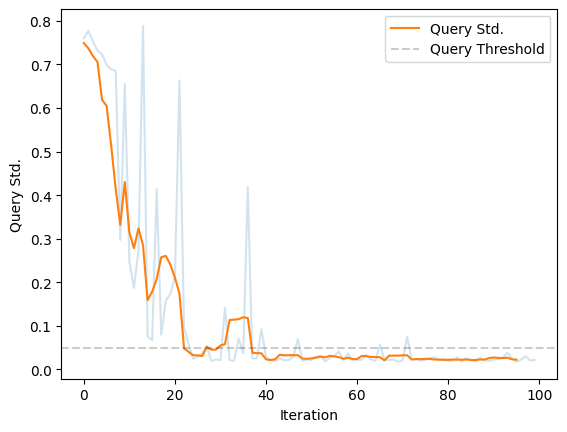

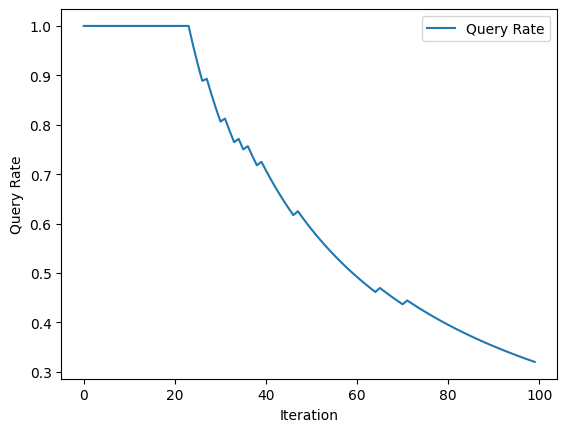

In [6]:
# Initialise
simulator = Sin()
X_train = LatinHypercube([(0, 50)]).sample(10)
Y_train = simulator(X_train)
learner = Threshold(
    simulator=simulator, 
    emulator=GP(), 
    X_train=X_train, Y_train=Y_train, 
    std_max=0.05
)

# Actively learn
for x in (pb := tqdm.tqdm(LatinHypercube([(0, 50)]).sample(100))):
    learner(x)
    pb.set_description(f"Query Std: {learner.stds[-1]:.2f}")

# Plot stds
window = 5
plt.plot(learner.stds, alpha=0.2)
plt.plot(np.convolve(learner.stds, np.ones(window) / window, mode='valid'), label='Query Std.')
plt.axhline(y=learner.std_max, color="k", linestyle="--", label="Query Threshold", alpha=0.2)
plt.xlabel('Iteration')
plt.ylabel('Query Std.')
plt.legend()
plt.show()

# Plot query rate
plt.plot(learner.rates, label="Query Rate")
plt.xlabel("Iteration")
plt.ylabel("Query Rate")
plt.legend()
plt.show()

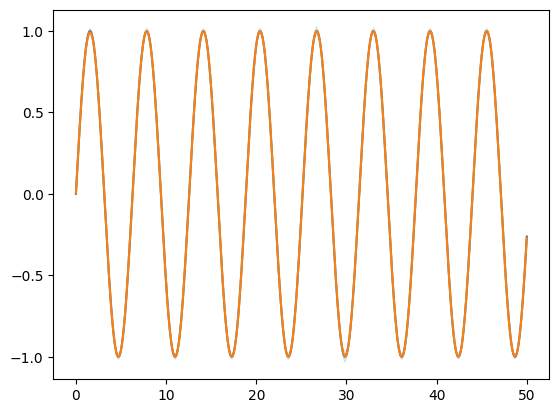

In [7]:
X_test = np.linspace(0, 50, 1000).reshape(-1, 1)
Y_test = learner.simulator(X_test)
Y_mean, Y_std = learner.emulator(X_test)
plt.plot(X_test.reshape(-1), Y_test.reshape(-1))
plt.plot(X_test.reshape(-1), Y_mean.reshape(-1))
plt.fill_between(
    X_test.reshape(-1), 
    Y_mean.reshape(-1) + Y_std.reshape(-1),
    Y_mean.reshape(-1) - Y_std.reshape(-1),
    alpha=0.2
)
plt.show()

## Stream-based query rate tracking
As seen above, the query standard deviation decreases below the threshold relatively quickly. However, in many real-world applications, we must also consider a labeling budget—i.e., how many samples we can afford to label.

With a simple modification of the `Threshold` learner, we can dynamically adjust the `std_max` threshold to maintain a desired query rate. This effectively introduces a feedback control mechanism that regulates the rate at which new samples are labeled.

In [8]:
@dataclass
class Target_Rate(Threshold):
    std_maxes: list = field(init=False, default_factory=list)
    adaption_rate: float
    target_rate: float

    def query(self, x):
        y_std = self.emulator(x.reshape(1, -1))[1][0][0]
        self.stds.append(y_std)
        rate = np.sum(np.array(self.stds) >= self.std_max) / len(self.stds)
        self.rates.append(rate)
        self.std_max += self.adaption_rate * (rate - self.target_rate)
        self.std_maxes.append(self.std_max)
        return y_std >= self.std_max

In [9]:
# Initialise
simulator = Sin()
X_train = LatinHypercube([(0, 50)]).sample(10)
Y_train = simulator(X_train)
learner = Target_Rate(
    simulator=simulator,
    emulator=GP(),
    X_train=X_train,
    Y_train=Y_train,
    std_max=0.02,
    target_rate=0.25,
    adaption_rate=1e-2
)

# Actively learn
for x in (pb := tqdm.tqdm(LatinHypercube([(0, 50)]).sample(1000))):
    learner(x)
    pb.set_description(
        f'Query Std: {learner.stds[-1]:.2f}, Rate: {learner.rates[-1]:.2f}, Threshold: {learner.std_maxes[-1]:.2f}'
    )

Query Std: 0.02, Rate: 0.25, Threshold: 0.03: 100%|██████████| 1000/1000 [00:05<00:00, 185.24it/s]


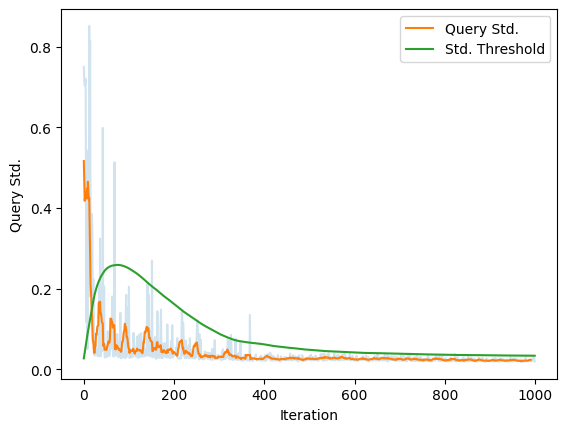

Text(0, 0.5, 'Query Rate')

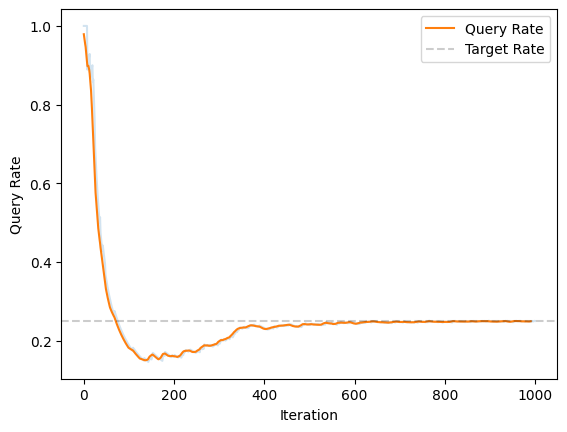

In [10]:
# Plot stds
window = 10
plt.plot(learner.stds, alpha=0.2)
plt.plot(np.convolve(learner.stds, np.ones(window) / window, mode='valid'), label='Query Std.')
plt.plot(learner.std_maxes, label='Std. Threshold')
plt.xlabel('Iteration')
plt.ylabel('Query Std.')
plt.legend()
plt.show()

# Plot rate
plt.plot(learner.rates, alpha=0.2)
plt.plot(np.convolve(learner.rates, np.ones(window) / window, mode='valid'), label='Query Rate')
plt.axhline(y=learner.target_rate, color="k", linestyle="--", label="Target Rate", alpha=0.2)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Query Rate')

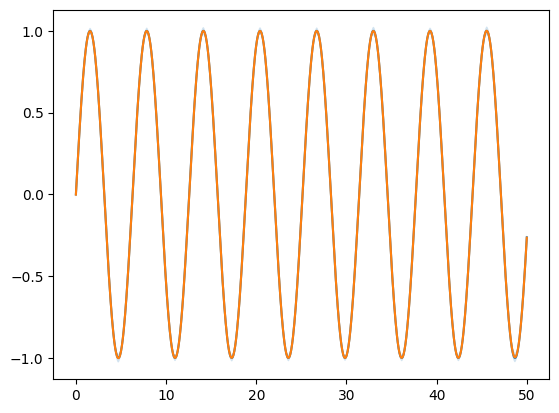

In [11]:
X_test = np.linspace(0, 50, 1000).reshape(-1, 1)
Y_test = learner.simulator(X_test)
Y_mean, Y_std = learner.emulator(X_test)
plt.plot(X_test.reshape(-1), Y_test.reshape(-1))
plt.plot(X_test.reshape(-1), Y_mean.reshape(-1))
plt.fill_between(
    X_test.reshape(-1), 
    Y_mean.reshape(-1) + Y_std.reshape(-1),
    Y_mean.reshape(-1) - Y_std.reshape(-1),
    alpha=0.2
)
plt.show()